In [1]:
from google.colab import files
import zipfile, os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Input, LeakyReLU, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
import os
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers


In [2]:
uploaded = files.upload()

zip_filename = next(iter(uploaded))
extract_dir = zip_filename.replace(".zip", "")

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

folder_path = os.path.join(extract_dir, 'B_23')
image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
print(f"Jumlah gambar: {len(image_files)}")

Saving B_23.zip to B_23.zip
Jumlah gambar: 1074


In [3]:
def load_images(path_list, base_path, size=(100, 100)):
    images = []
    for fname in path_list:
        img = Image.open(os.path.join(base_path, fname)).convert("RGB")
        img = img.resize(size)
        img_arr = np.array(img).astype(np.float32)
        img_arr = (img_arr / 127.5) - 1.0
        images.append(img_arr)
    return np.array(images)

In [4]:
images = load_images(image_files, folder_path)

In [5]:
from tensorflow.keras.layers import ZeroPadding2D

def build_generator(latent_dim=100):
    model = tf.keras.Sequential()
    # Dense layer ke 106*106*16 untuk reshape awal
    model.add(layers.Dense(106 * 106 * 16, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((106, 106, 16)))

    # 3 Conv2D layer dengan padding 'valid', kernel 3x3, stride 1
    model.add(layers.Conv2D(16, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(3, (3, 3), strides=1, padding='valid', activation='tanh'))

    return model

In [6]:
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")

    # Input shape: 100x100x3
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(100, 100, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Output: real/fake

    return model

In [8]:
latent_dim = 100

generator = build_generator(latent_dim)
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
discriminator.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
discriminator.trainable = True

gan_input = Input(shape=(latent_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = tf.keras.Model(gan_input, gan_output)

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        images_noisy = images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.05)
        generated_images_noisy = generated_images + tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.05)

        real_output = discriminator(images_noisy, training=True)
        fake_output = discriminator(generated_images_noisy, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [13]:
  def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")

In [14]:
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 200
train(train_dataset, EPOCHS)

Epoch 1, Generator Loss: 3.9264, Discriminator Loss: 0.3564
Epoch 2, Generator Loss: 5.3433, Discriminator Loss: 0.3331
Epoch 3, Generator Loss: 4.4685, Discriminator Loss: 0.3564
Epoch 4, Generator Loss: 4.9670, Discriminator Loss: 0.3422
Epoch 5, Generator Loss: 4.8267, Discriminator Loss: 0.3611
Epoch 6, Generator Loss: 3.3953, Discriminator Loss: 0.4034
Epoch 7, Generator Loss: 0.7784, Discriminator Loss: 1.1113
Epoch 8, Generator Loss: 1.4307, Discriminator Loss: 0.8404
Epoch 9, Generator Loss: 0.9518, Discriminator Loss: 1.1356
Epoch 10, Generator Loss: 1.1316, Discriminator Loss: 1.0652
Epoch 11, Generator Loss: 1.1220, Discriminator Loss: 1.1886
Epoch 12, Generator Loss: 1.1781, Discriminator Loss: 1.1687
Epoch 13, Generator Loss: 1.2823, Discriminator Loss: 1.2235
Epoch 14, Generator Loss: 0.8846, Discriminator Loss: 1.1313
Epoch 15, Generator Loss: 1.2066, Discriminator Loss: 1.4952
Epoch 16, Generator Loss: 0.7467, Discriminator Loss: 1.0700
Epoch 17, Generator Loss: 0.8510,

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm

# Load model InceptionV3 tanpa fully connected layer
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
def calculate_fid(model, real_images, generated_images):
    real_images = tf.image.resize(real_images, (75, 75))
    generated_images = tf.image.resize(generated_images, (75, 75))

    act1 = model.predict(preprocess_input(real_images * 127.5 + 127.5))
    act2 = model.predict(preprocess_input(generated_images * 127.5 + 127.5))

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [17]:
generator = build_generator()

latent_dim = 100
num_samples = 32
noise = tf.random.normal([num_samples, latent_dim])
generated_images = generator(noise, training=False)

real_images = np.array(images[:num_samples])

fid_score = calculate_fid(inception_model, real_images, generated_images)
print(f"FID Score: {fid_score:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
FID Score: 3633.10


Sample gambar asli:


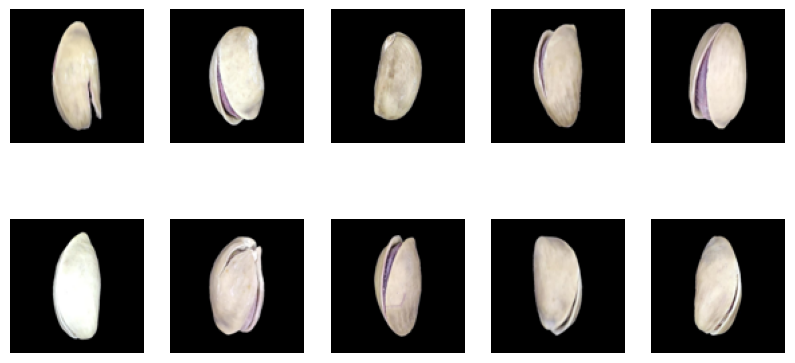


Sample gambar hasil generate:


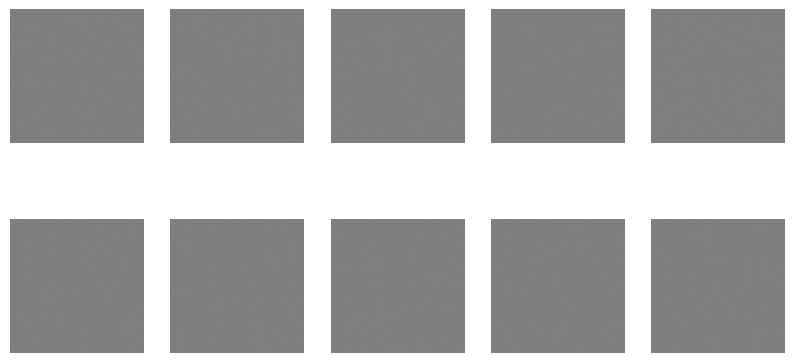

In [18]:
import numpy as np
import matplotlib.pyplot as plt

print("Sample gambar asli:")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Konversi dari range [-1, 1] ke [0, 1]
    img = (images[i] + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

print("\nSample gambar hasil generate:")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Konversi dari range [-1, 1] ke [0, 1]
    img = (generated_images[i].numpy() + 1) / 2
    # Pastikan nilai dalam rentang [0, 1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## NO 3B

### modifikasi generator

In [19]:
latent_dim = 100

def build_generator_mod(latent_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*64, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((25, 25, 64)))  # 25x25x64

    # Gunakan padding='same' untuk mempertahankan dimensi
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Tambahkan Upsampling supaya dari 25x25 ke 100x100
    model.add(layers.UpSampling2D(size=(4,4)))  # 25x4=100

    # Output layer 3 channel dengan tanh activation (range [-1,1])
    model.add(layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh'))
    return model

### modifikasi discriminator

In [20]:
def build_discriminator_mod(input_shape=(100, 100, 3)):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    # Output tanpa aktivasi, pakai from_logits=True pada loss
    model.add(layers.Dense(1))
    return model

### inisialisasi model

In [21]:
generator = build_generator_mod()
discriminator = build_discriminator_mod()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### optimizer & training

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

### loss function binary crossentroophy

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### training step function

In [24]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

training loop function

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_avg = 0
        disc_loss_avg = 0
        batch_count = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg += gen_loss
            disc_loss_avg += disc_loss
            batch_count += 1

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss_avg/batch_count:.4f}, Discriminator Loss: {disc_loss_avg/batch_count:.4f}")

EPOCHS = 200
train(train_dataset, EPOCHS)

Epoch 1, Generator Loss: 3.3205, Discriminator Loss: 0.1955
Epoch 2, Generator Loss: 2.0712, Discriminator Loss: 0.5552
Epoch 3, Generator Loss: 1.8712, Discriminator Loss: 0.5494
Epoch 4, Generator Loss: 1.8822, Discriminator Loss: 0.5599
Epoch 5, Generator Loss: 1.7056, Discriminator Loss: 0.6017
Epoch 6, Generator Loss: 1.3815, Discriminator Loss: 0.8441
Epoch 7, Generator Loss: 1.3128, Discriminator Loss: 0.8774
Epoch 8, Generator Loss: 1.3531, Discriminator Loss: 0.7437
Epoch 9, Generator Loss: 1.4068, Discriminator Loss: 0.6942
Epoch 10, Generator Loss: 1.4978, Discriminator Loss: 0.5744
Epoch 11, Generator Loss: 1.6619, Discriminator Loss: 0.4714
Epoch 12, Generator Loss: 1.8369, Discriminator Loss: 0.4076
Epoch 13, Generator Loss: 1.9726, Discriminator Loss: 0.3417
Epoch 14, Generator Loss: 2.0909, Discriminator Loss: 0.3054
Epoch 15, Generator Loss: 2.2718, Discriminator Loss: 0.2450
Epoch 16, Generator Loss: 2.4055, Discriminator Loss: 0.2183
Epoch 17, Generator Loss: 2.4909,

In [26]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm

inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def preprocess_for_inception(images):
    # images dalam range [-1,1], ubah ke [0,255]
    images = (images + 1.0) * 127.5
    images = tf.image.resize(images, (299, 299))
    return images

def get_inception_features(images):
    images = preprocess_for_inception(images)
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    features = inception_model(images)
    return features.numpy()

def calculate_fid(real_images, generated_images):
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(generated_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

noise = tf.random.normal([len(real_images), latent_dim])
generated_images = generator(noise, training=False).numpy()

real_images = real_images.astype(np.float32)
generated_images = generated_images.astype(np.float32)

fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score:.2f}")

FID Score: 334.37


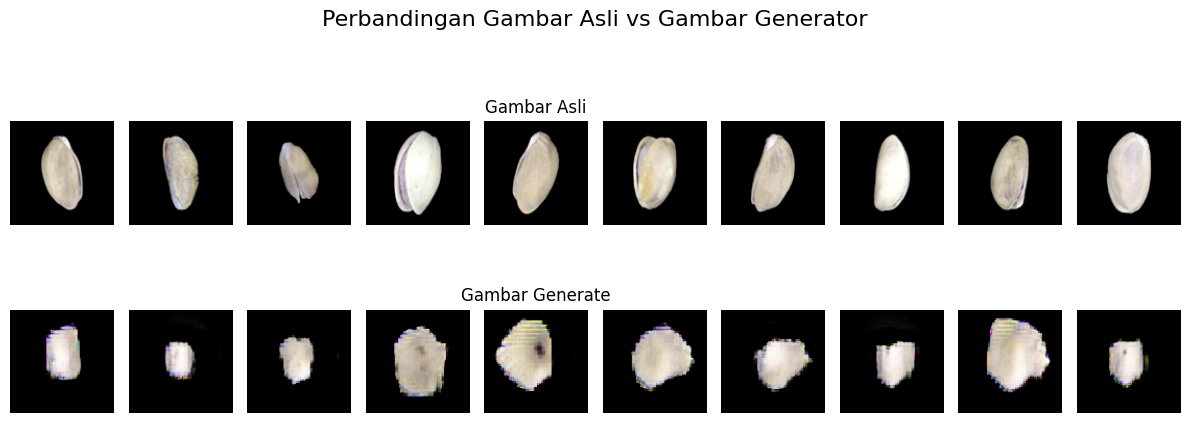

In [27]:
for real_images_batch in train_dataset.take(1):
    real_images = real_images_batch[:10]

noise = tf.random.normal([10, 100])
generated_images = generator(noise, training=False)

plt.figure(figsize=(12, 5))

for i in range(10):
    plt.subplot(2, 10, i + 1)
    img = (real_images[i].numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    if i == 4:
        plt.title("Gambar Asli")

for i in range(10):
    plt.subplot(2, 10, 10 + i + 1)
    img = (generated_images[i].numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    if i == 4:
        plt.title("Gambar Generate")

plt.suptitle("Perbandingan Gambar Asli vs Gambar Generator", fontsize=16)
plt.tight_layout()
plt.show()


linkk video : https://youtu.be/YPp173FZnOQ